
# Galaxies vs quasars with neural networks

Let's go back to our galaxy vs quasar data we've used in a previous exercise.

- Read in SDSS galaxy color data from solutions/galaxyquasar.csv. Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$.

- Now we're going to fit a neural network classifier. First, scale your data appropriately and do a 30% train/test split.

- Now train the classifier. Use a package among those we've seen. These include Tensorflow via keras, pytorch, and the MPL classifier implemented in scikit-learn. This is an opportunity to pick the one you're most interested in learning.

- Start from a network architecture with a single hidden layer with 5 neurons, using the adam solver, the relu activation function, and a learning rate of $0.001$. Plot the resulting ROC curve.

- Now let's optimize the hyperparameters of your network. Explore different hyperparameters and see what fits the data best. Do your best now to optimize the network architecture. Be creative!

- Is your best result comparable with the simpler classifiers we've seen before? Do we need deep learning here? If yes, which features are captured best?

A few tips:

- In scikit-learn, remember that you can utilize all availables cores on your machine with n_jobs=-1. Print out the classification score for the training data, and the best parameters obtained by the cross validation.

- If it takes too long, run the hyperparameter optimization on a subset of the training set. Then retrain the full network using the best hyperparameters only.

- On cross validation, for scikit learn we've seen how to use GridSearchCV already. For Tensorflow, there's a really cool tool called Tensorboard.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_csv('galaxyquasar.csv')
data

,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,QSO,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,GALAXY,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,GALAXY,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,GALAXY,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,QSO,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,GALAXY,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,GALAXY,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,GALAXY,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,GALAXY,0.112571,0.000009


In [11]:
usecols = ['u', 'g', 'r', 'i', 'z', 'class', 'z1', 'zerr']

u_g = np.array(data.get(usecols[0]) - data.get(usecols[1]))
g_r = np.array(data.get(usecols[1]) - data.get(usecols[2]))
r_i = np.array(data.get(usecols[2]) - data.get(usecols[3]))
i_z = np.array(data.get(usecols[3]) - data.get(usecols[4]))

target = np.array(data.get(usecols[5]))

X=np.array([u_g, g_r, r_i, i_z]).T
y = np.empty(shape = u_g.size)     # Class labels

for i, label in enumerate(target):
    if (label == 'GALAXY'): y[i] = 0
    elif (label == 'QSO'): y[i] = 1

Let's first display the plots from the L19 exercise, to get an idea of the data:

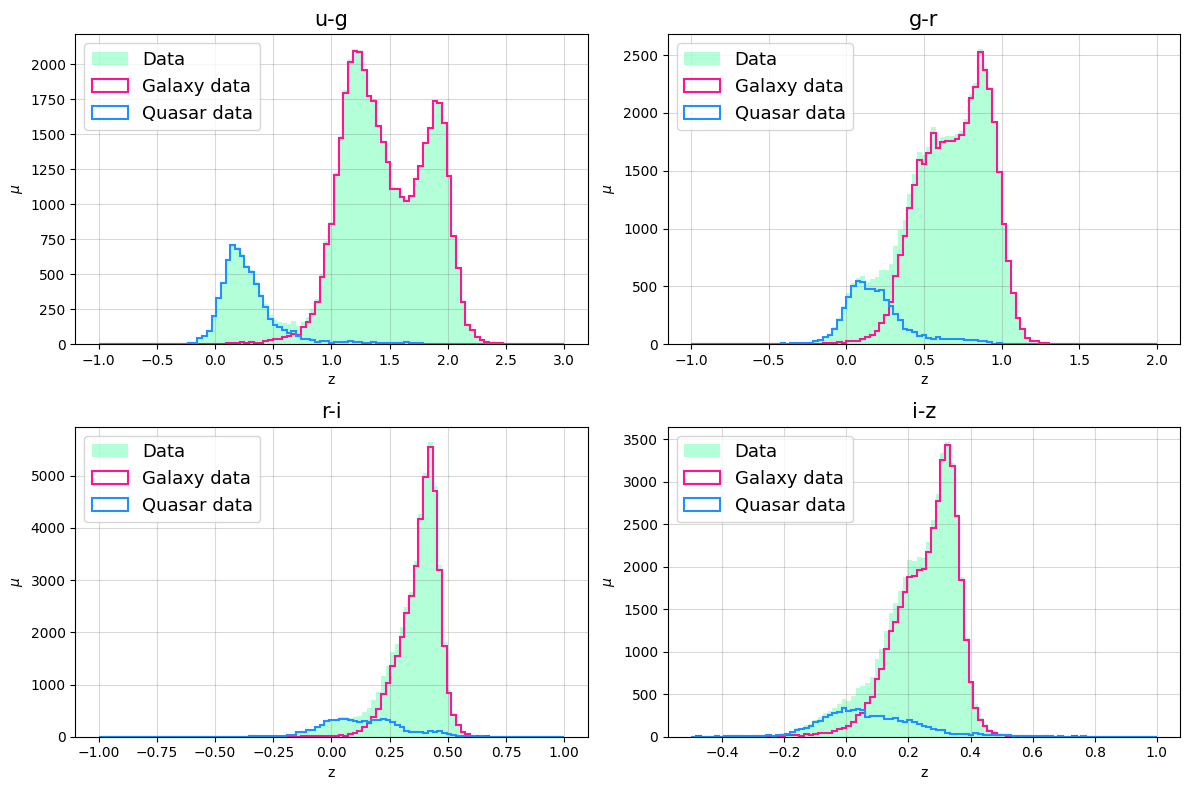

In [4]:
data_array = [u_g, g_r, r_i, i_z]
titles = ['u-g', 'g-r', 'r-i', 'i-z']
bins = [np.linspace(-1, 3, 100), np.linspace(-1, 2, 100), np.linspace(-1, 1, 100), np.linspace(-0.5, 1, 100)]

fig = plt.figure(figsize=(12, 8))
axes = []

for i, col in enumerate(data_array):
    ax = fig.add_subplot(2,2,1+i)
    axes.append(ax)
    plt.hist(col, bins = bins[i], color = 'springgreen', alpha = 0.3, label = 'Data')
    plt.hist(col[y==0], bins = bins[i], histtype = 'step', color = 'deeppink', linewidth = 1.5, alpha = 1, label = 'Galaxy data')
    plt.hist(col[y==1], bins = bins[i], histtype = 'step', color = 'dodgerblue', linewidth = 1.5, alpha = 1, label = 'Quasar data')
    ax.grid(c='grey', alpha = 0.2)
    ax.set_xlabel('z')
    ax.set_ylabel('$\\mu$')
    ax.set_title(titles[i], fontsize = 15)
    ax.grid(alpha=0.3, c='gray')
    ax.legend(loc='upper left', fontsize = 13)

plt.tight_layout()
plt.show()

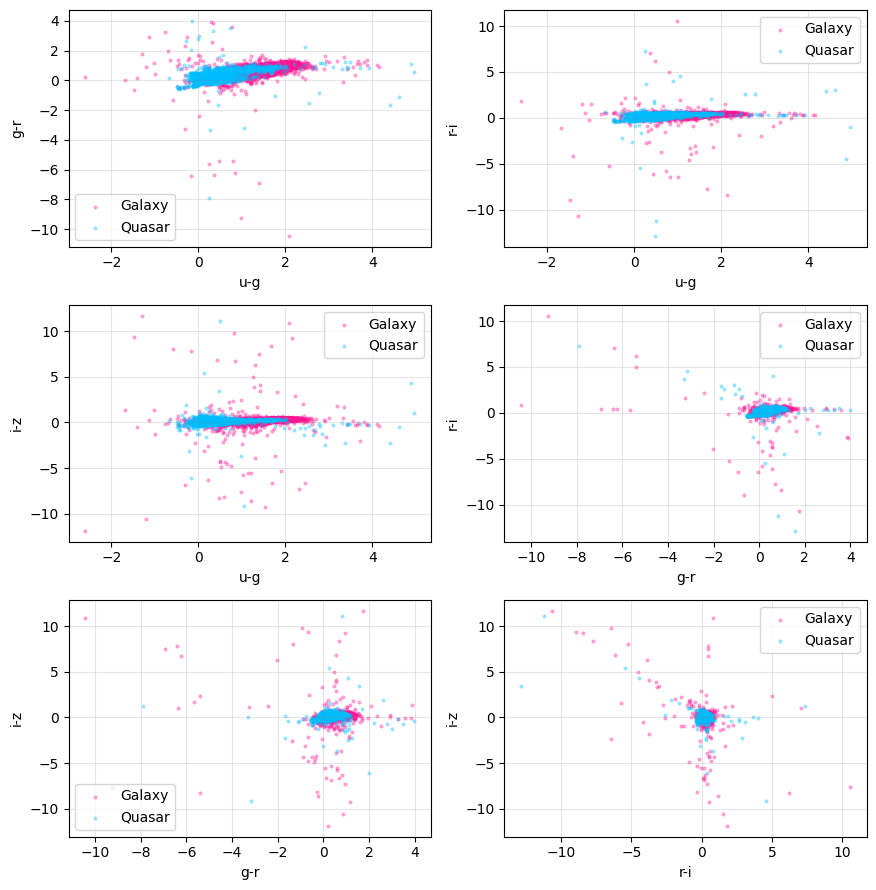

In [5]:
# I could've used corner for the next plots, but the contours were very small and I didn't get a clear idea of the data.

fig, axes = plt.subplots(3, 2, figsize = (9, 9))

axes[0, 0].scatter(u_g[y==0], g_r[y==0], s = 4, c = 'deeppink', alpha = 0.3, label = 'Galaxy')
axes[0, 0].scatter(u_g[y==1], g_r[y==1], s = 4, c = 'deepskyblue', alpha = 0.3, label = 'Quasar')
axes[0, 0].grid(c='grey', alpha = 0.2)
axes[0, 0].set_xlabel('u-g')
axes[0, 0].set_ylabel('g-r')
axes[0, 0].legend()

axes[0, 1].scatter(u_g[y==0], r_i[y==0], s = 4, c = 'deeppink', alpha = 0.3, label = 'Galaxy')
axes[0, 1].scatter(u_g[y==1], r_i[y==1], s = 4, c = 'deepskyblue', alpha = 0.3, label = 'Quasar')
axes[0, 1].grid(c='grey', alpha = 0.2)
axes[0, 1].set_xlabel('u-g')
axes[0, 1].set_ylabel('r-i')
axes[0, 1].legend()


axes[1, 0].scatter(u_g[y==0], i_z[y==0], s = 4, c = 'deeppink', alpha = 0.3, label = 'Galaxy')
axes[1, 0].scatter(u_g[y==1], i_z[y==1], s = 4, c = 'deepskyblue', alpha = 0.3, label = 'Quasar')
axes[1, 0].grid(c='grey', alpha = 0.2)
axes[1, 0].set_xlabel('u-g')
axes[1, 0].set_ylabel('i-z')
axes[1, 0].legend()

axes[1, 1].scatter(g_r[y==0], r_i[y==0], s = 4, c = 'deeppink', alpha = 0.3, label = 'Galaxy')
axes[1, 1].scatter(g_r[y==1], r_i[y==1], s = 4, c = 'deepskyblue', alpha = 0.3, label = 'Quasar')
axes[1, 1].grid(c='grey', alpha = 0.2)
axes[1, 1].set_xlabel('g-r')
axes[1, 1].set_ylabel('r-i')
axes[1, 1].legend()

axes[2, 0].scatter(g_r[y==0], i_z[y==0], s = 4, c = 'deeppink', alpha = 0.3, label = 'Galaxy')
axes[2, 0].scatter(g_r[y==1], i_z[y==1], s = 4, c = 'deepskyblue', alpha = 0.3, label = 'Quasar')
axes[2, 0].grid(c='grey', alpha = 0.2)
axes[2, 0].set_xlabel('g-r')
axes[2, 0].set_ylabel('i-z')
axes[2, 0].legend()

axes[2, 1].scatter(r_i[y==0], i_z[y==0], s = 4, c = 'deeppink', alpha = 0.3, label = 'Galaxy')
axes[2, 1].scatter(r_i[y==1], i_z[y==1], s = 4, c = 'deepskyblue', alpha = 0.3, label = 'Quasar')
axes[2, 1].grid(c='grey', alpha = 0.2)
axes[2, 1].set_xlabel('r-i')
axes[2, 1].set_ylabel('i-z')
axes[2, 1].legend()

plt.tight_layout()
plt.show()


### Scaling and train-test splitting


In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=336)

# Starting with a data subset
X_train_sub = X_train[::10]     # N = 5000
X_test_sub = X_test[::10]
y_train_sub = y_train[::10]
y_test_sub = y_test[::10]

In [18]:
print(X_train_sub.shape)
print(X_test_sub.shape)

(3500, 4)
(1500, 4)



## Classifier - first approach

- Single hidden layer with 5 neurons
- Activation function: ReLU
- Learning rate: $0.001$

Let's start with a fully connected network.

In [23]:
# https://www.educative.io/answers/how-to-build-a-simple-neural-network-using-keras

from keras.models import Sequential     # Used to build the model
from keras.layers import Dense, Input     # Type of layer

In [24]:
# Building the model
model = Sequential()
model.add(Input(shape=(4,)))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='relu'))

In [25]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [28]:
model.fit(X_train_sub, y_train_sub, epochs=10, batch_size=10)

Epoch 1/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9783 - loss: 0.1820
Epoch 2/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9768 - loss: 0.1615
Epoch 3/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9765 - loss: 0.1937
Epoch 4/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9786 - loss: 0.1482
Epoch 5/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9763 - loss: 0.1624
Epoch 6/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9806 - loss: 0.1260
Epoch 7/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9772 - loss: 0.1489
Epoch 8/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9800 - loss: 0.1293
Epoch 9/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9823 - loss: 0.1183
Epoch 10/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9783 - loss: 0.1320


In [30]:
loss, accuracy = model.evaluate(X_test_sub, y_test_sub)
print('Test model loss: %.3f' % loss)
print('Test model accuracy: %.3f' % accuracy)

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9823 - loss: 0.1287
Test model loss: 0.145
Test model accuracy: 0.979
